If using google drive please edit this line to connect to drive location

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# from google.colab import drive
import os, sys

# # Mount the google colab
# drive.mount("/content/drive/")
# GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'DeepLearning_GroupProject/'
# GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
# !ls {GOOGLE_DRIVE_PATH}
# sys.path.append(GOOGLE_DRIVE_PATH)

GOOGLE_DRIVE_PATH = '.'


# relative paths
models_dir = 'models'
csv_path = 'Data/updated_data_with_lists.csv'
tensors_dir = 'Data/tensor_batch_notaugmented'

In [3]:
import pandas as pd
from ast import literal_eval
import numpy as np
import torch
import optuna


# Explicitly adding models to the search path
models_path = os.path.join(GOOGLE_DRIVE_PATH, models_dir)
if models_path not in sys.path:
    sys.path.insert(0, models_path)

from models import recipe_encoder

csv_file = os.path.join(GOOGLE_DRIVE_PATH,csv_path)
df = pd.read_csv(csv_file, converters={"Cleaned_Ingredients": literal_eval, "Instructions": literal_eval})
print(len(df))
df.head()

13496


,Unnamed: 0,Title,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"[Pat chicken dry with paper towels, season all...",miso-butter-roast-chicken-acorn-squash-panzanella,"[1 (3½–4-lb.) whole chicken, 2¾ tsp. kosher sa..."
1,1,Crispy Salt and Pepper Potatoes,[Preheat oven to 400°F and line a rimmed bakin...,crispy-salt-and-pepper-potatoes-dan-kluger,"[2 large egg whites, 1 pound new potatoes (abo..."
2,2,Thanksgiving Mac and Cheese,[Place a rack in middle of oven; preheat to 40...,thanksgiving-mac-and-cheese-erick-williams,"[1 cup evaporated milk, 1 cup whole milk, 1 ts..."
3,3,Italian Sausage and Bread Stuffing,[Preheat oven to 350°F with rack in middle. Ge...,italian-sausage-and-bread-stuffing-240559,"[1 (¾- to 1-pound) round Italian loaf, cut int..."
4,4,Newton's Law,[Stir together brown sugar and hot water in a ...,newtons-law-apple-bourbon-cocktail,"[1 teaspoon dark brown sugar, 1 teaspoon hot w..."


Concatenate the batches of preprocessed images into 1 tensor

In [4]:
pt_files = os.listdir(os.path.join(GOOGLE_DRIVE_PATH,tensors_dir))
all_image_tensors = []
all_image_labels = []

# Load and combine all .pt files
for pt_file in pt_files[:5]:
    pt_filepath = os.path.join(GOOGLE_DRIVE_PATH,tensors_dir,pt_file)
    image_tensors, image_labels = torch.load(pt_filepath)
    all_image_tensors.append(image_tensors)
    all_image_labels.extend(image_labels)
    print(f"Loaded {pt_file}")

# Concatenate tensors
all_image_tensors = torch.cat(all_image_tensors)
print(f"Number of images: {all_image_tensors.size(0)}")
print(f"Number of labels: {len(all_image_labels)}")
assert all_image_tensors.size(0) == len(all_image_labels), "Mismatch between images and labels!"

/tmp/ipykernel_25734/3557820744.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensors, image_labels = torch.load(pt_filepath)


Loaded batch_6.pt
Loaded batch_7.pt
Loaded batch_0.pt
Loaded batch_11.pt
Loaded batch_10.pt
Number of images: 5000
Number of labels: 5000


Reorganize dataframe to be in the same order as the Image Tensors using the image_label as the matching key

In [5]:
##Reset order of dataframe to match the image labels orders
all_image_labels_cleaned = [label.split(".")[0] for label in all_image_labels] #remove the .png and .jgp
print(all_image_labels_cleaned[:10]) #print to see if at the end the df matches

filtered_df = df[df["Image_Name"].isin(all_image_labels_cleaned)] #filter the df to only have values from the images
print(filtered_df["Image_Name"][:10])
print(df.shape)
print(filtered_df.shape, len(all_image_labels_cleaned))

valid_labels = set(filtered_df['Image_Name'])

# Filter labels and tensors
filtered_labels_and_tensors = [
    (tensor, label) for tensor, label in zip(all_image_tensors, all_image_labels_cleaned) if label in valid_labels
]

# Unpack the filtered data
filtered_tensors, filtered_labels = zip(*filtered_labels_and_tensors)

# Convert back to tensors
filtered_tensors = torch.stack(filtered_tensors)
filtered_labels = list(filtered_labels)

# Verify alignment
print(f"Number of filtered tensors: {len(filtered_tensors)}")
print(f"Number of filtered labels: {len(filtered_labels)}")
print(f"Number of rows in filtered_df: {len(filtered_df)}")

# Finally reorganize the df to be in the same order as the image tensors
filtered_df = filtered_df.set_index("Image_Name").loc[filtered_labels].reset_index()
print(filtered_df["Image_Name"][:10])

['lemon-rhubarb-chicken-237100', 'maple-soy-barbecue-grilled-chicken', 'little-gem-wedge-salad-with-tahini-ranch', 'lemon-balm-honeysuckle-366697', 'nectarine-and-peach-salad-with-pecans-blue-cheese-and-lavender-syrup', 'old-fashioned-fruitcake-cookies-350832', 'kona-swizzle-394668', 'lemon-souffles-with-boysenberries-241606', 'lemony-green-beans-and-peas-368550', 'miso-cured-black-cod-with-chilled-cucumbers-56389995']
1      crispy-salt-and-pepper-potatoes-dan-kluger
3       italian-sausage-and-bread-stuffing-240559
4              newtons-law-apple-bourbon-cocktail
5            warm-comfort-tequila-chamomile-toddy
7               turmeric-hot-toddy-claire-sprouse
10       hot-pimento-cheese-dip-polina-chesnakova
12             butternut-squash-apple-soup-365210
13                     caesar-salad-roast-chicken
14    chicken-and-rice-with-leeks-and-salsa-verde
17                   caramelized-plantain-parfait
Name: Image_Name, dtype: object
(13496, 5)
(4969, 5) 5000
Number of filtered 

In [6]:
filtered_df.head()

,Image_Name,Unnamed: 0,Title,Instructions,Cleaned_Ingredients
0,lemon-rhubarb-chicken-237100,11165,Lemon-Rhubarb Chicken,[Heat 2 tablespoons olive oil in heavy large s...,"[5 tablespoons olive oil, divided, 2 tablespoo..."
1,maple-soy-barbecue-grilled-chicken,57,Maple Barbecue Grilled Chicken,[Heat olive oil in a small saucepan over mediu...,"[2 Tbsp. extra-virgin olive oil, 3 garlic clov..."
2,little-gem-wedge-salad-with-tahini-ranch,1300,Little Gem Wedge Salad with Tahini Ranch,"[Whisk garlic, yogurt, tahini, lemon juice, an...","[1 small garlic clove, finely grated, 1 cup pl..."
3,lemon-balm-honeysuckle-366697,6946,Lemon Balm Honeysuckle,[Stir honey and 6 tablespoons hot water in a l...,"[6 tablespoons honey, 2 cups lemon vodka or wh..."
4,nectarine-and-peach-salad-with-pecans-blue-che...,1924,Nectarines and Peaches with Lavender Syrup,[Preheat oven to 350°F. Toast pecans on a rimm...,"[1/2 cup pecans, 3 tablespoons honey, 2 tables..."


Reformat Ingredients, Recipes, and Image titles

Tokenize Recipes, Ingredients, and Image Titles

In [7]:
from transformers import AutoTokenizer
total_max = 128
# Initialize the tokenizer
tokenizer_recipes = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_nested_list(nested_list, max_length=128):
    """
    Tokenizes a nested list of strings (list of ingredients per recipe).
    Each inner list is tokenized into a list of token IDs.
    """
    tokenized_list = []
    for sublist in nested_list:
        # Join the inner list into a string
        # text = " ".join(sublist)
        text = str(sublist)
        # Tokenize the string
        tokens = tokenizer_recipes(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # Append tokenized input_ids to the result list
        tokenized_list.append(tokens["input_ids"].squeeze(0).tolist())
    return tokenized_list

filtered_df['Title_List'] = df['Title'].apply(lambda x: [x])
filtered_df['tokenized_ingredients'] = filtered_df['Cleaned_Ingredients'].apply(lambda x: tokenize_nested_list(x, total_max))
filtered_df['tokenized_instructions'] = filtered_df['Instructions'].apply(lambda x: tokenize_nested_list(x, total_max))
filtered_df['tokenized_titles'] = filtered_df['Title_List'].apply(lambda x: tokenize_nested_list(x, total_max))


# # Store tokenized data in a dictionary for your DataLoader
# filtered_df["tokenized_titles"] = title_tokens["input_ids"]
# filtered_df["title_attention_mask"] = title_tokens["attention_mask"]

# filtered_df["tokenized_ingredients"] = ingredients_tokens["input_ids"]
# filtered_df["ingredients_attention_mask"] = ingredients_tokens["attention_mask"]

# filtered_df["tokenized_instructions"] = instructions_tokens["input_ids"]
# filtered_df["instructions_attention_mask"] = instructions_tokens["attention_mask"]
print(len(filtered_df["tokenized_titles"][0]))
print(filtered_df["tokenized_ingredients"][0])
print(filtered_df["tokenized_instructions"][0])


/home/chelsea/anaconda3/envs/tfood_torch/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


1
[[101, 1019, 7251, 24667, 3619, 9724, 3514, 1010, 4055, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1016, 7251, 24667, 3619, 4606, 1015, 1013, 1018, 2452, 24881, 4618, 12868, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1018, 1015, 1013, 1016, 10268, 18740, 2094, 1054, 6979, 8237, 2497, 1010, 4055, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
def pad_or_truncate_nested(sublist, target_length, max_length, pad_token=0):
        """
            Pad or truncate the outer list of a nested list to match the target_length.
            Each inner list remains untouched.
        """
        # Pad with [pad_token] or truncate the outer list
        if len(sublist) < target_length:
            sublist.extend([[pad_token]* max_length] * (target_length - len(sublist)))
        else:
            sublist = sublist[:target_length]
        return sublist

max_length_ing = filtered_df['tokenized_ingredients'].apply(len).max()
max_length_inst = filtered_df['tokenized_instructions'].apply(len).max()//4
max_length_title = filtered_df['tokenized_titles'].apply(len).max()
filtered_df['tokenized_ingredients'] = filtered_df['tokenized_ingredients'].apply(
    lambda ing: pad_or_truncate_nested(ing, max_length_ing,total_max))

filtered_df['tokenized_instructions'] = filtered_df['tokenized_instructions'].apply(
    lambda inst: pad_or_truncate_nested(inst, max_length_inst, total_max))
# new_token_ing = [pad_or_truncate_nested(ing, max_length_title) for ing in tokenized_ingredients] #titles were all list length of 1
max_length_ing = filtered_df['tokenized_ingredients'].apply(len).max()
max_length_inst = filtered_df['tokenized_instructions'].apply(len).max()
max_length_title = filtered_df['tokenized_titles'].apply(len).max()
print(max_length_ing, max_length_inst, max_length_title)
print(len(filtered_df['tokenized_ingredients'][5]))
print(filtered_df['tokenized_ingredients'][100])

51 22 1
51
[[101, 1015, 9044, 2598, 4977, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1017, 1013, 1018, 2452, 4840, 7852, 13675, 25438, 2015, 1006, 2013, 1016, 25609, 2422, 2878, 1011, 10500, 7852, 1007, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1015, 1013, 1016, 2452, 22126, 24881, 29259, 2401, 2030, 2060, 4086, 24444, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Tokenize the Image Labels for the Image Encoder

In [9]:
from transformers import AutoTokenizer
from transformers import CLIPModel
model_name = "openai/clip-vit-base-patch16"
clip_model = CLIPModel.from_pretrained(model_name)
tokenizer_images = AutoTokenizer.from_pretrained(model_name)

tokenized_labels = tokenizer_images(
    filtered_labels,
    padding="max_length",
    truncation=True,
    max_length=tokenizer_images.model_max_length,
    return_tensors="pt"
)

/home/chelsea/anaconda3/envs/tfood_torch/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
%reload_ext autoreload


cuda:0


In [11]:
import torch.nn as nn
class RecipeDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(RecipeDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

    def forward(self, input_tokens):
        embedded = self.embedding(input_tokens)
        outputs, hidden_state = self.rnn(embedded, hidden_state)
        predictions = self.fc_out(outputs)
        return predictions

In [12]:
def calc_recall(top, image_features, recipe_embeddings, image_labels):
  true_pos = 0
  false_neg = 0
  tmp_batches = image_features.shape[0]
  print(image_features.shape, recipe_embeddings.shape)
  for i in range(tmp_batches):
    cosine_similarity = torch.nn.CosineSimilarity(dim=1)
    similarities = cosine_similarity(image_features[i, :].unsqueeze(0), recipe_embeddings)
    print(similarities)
    #top = amount of top results to retrieve
    top_results = top
    top_k_values, top_k_indices = torch.topk(similarities, top_results, largest=True)
    print(top_k_values, top_k_indices)
    top_images = [(filtered_df['Image_Name'][i]) for i in top_k_indices]
    if image_labels[i] in [image[0] for image in top_images]:
      true_pos += 1
    else:
      false_neg += 1

  return (true_pos / tmp_batches)


In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from models.image_2_recipe import Image2Recipe
from models.image_encoder import Image_Encoder
from models.recipe_encoder import RecipeEncoder
from models.MMR import MMR
from models.MMR import MMR_losses
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime


class Data_Loading(Dataset):
    """
    Class to combine the Images, Labels, Recipes together to be used in combination when inputted into Model
    """
    def __init__(self, tokenized_ingredients, tokenized_instructions, tokenized_titles, image_tensors, image_labels):
        self.ingredients = torch.tensor(tokenized_ingredients, dtype=torch.int16)
        self.instructions = torch.tensor(tokenized_instructions, dtype=torch.int16)
        self.titles = torch.tensor(tokenized_titles, dtype=torch.int16)
        self.images = image_tensors
        self.image_labels = image_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "ingredients": self.ingredients[idx],
            "instructions": self.instructions[idx],
            "titles": self.titles[idx],
            "images": self.images[idx],
            "image_labels": self.image_labels[idx]
            # "tokenized_labels": {
            #     "input_ids": self.tokenized_labels['input_ids'][idx].to(dtype=torch.long),
            #     "attention_mask": self.tokenized_labels['attention_mask'][idx].to(dtype=torch.uint8)
            # }
        }



class Trainer(object):
    """
    Class designed to run ViT (train, evaluate, plot)
    """

    def __init__(self, **kwargs):
        """
        Initialize ViT
        """
        self.epochs = kwargs['epochs']
        self.optimizer_name = kwargs['optimizer']
        self.device = kwargs['device']
        self.batch_size = kwargs['batch_size']
        self.lr = kwargs['learning_rate']

        self.tokenized_ingredients = kwargs['ingredient_tokens']
        self.tokenized_instructions = kwargs['instruction_tokens']
        self.tokenized_title = kwargs['title_tokens']
        self.image_tensor = kwargs['image_tensors']
        self.image_labels = kwargs['image_labels']
        self.clip_model = kwargs['clip_model']
        self.vocab_size = kwargs['vocab_size']
        self.max_len = kwargs['max_len']
        self.instance_weight = kwargs['instance_weight']
        self.sem_weight = kwargs['sem_weight']
        self.itm_weight = kwargs['itm_weight']
        self.best_model_parameters = kwargs['best_model_parameters_path']
        # self.margin = kwargs['margin']
        self.initial_margin = kwargs['initial_margin']
        self.margin_step = kwargs['margin_step']
        self.max_margin = kwargs['max_margin']
        self.topk = kwargs['topk']
        # Pending variable margin calc
        # self.loss_calcs = MMR_losses(margin=1.0, instance_weight=self.instance_weight, sem_weight=self.sem_weight, itm_weight=self.itm_weight)
        self.loss_calcs = MMR_losses(instance_weight=self.instance_weight, sem_weight=self.sem_weight, itm_weight=self.itm_weight)
        # num_classes = len(set(self.image_labels['input_ids']))
        num_classes = len(set(self.image_labels))
        # print(num_classes)


        self.image_encoder = Image_Encoder(self.device, self.clip_model, num_classes).to(self.device)
        self.recipe_encoder = RecipeEncoder(self.device, self.vocab_size, self.max_len).to(self.device)
        self.mmr = MMR(hidden_dim=self.image_encoder.clip_model.config.projection_dim).to(self.device)
        # self.recipe_decoder = RecipeDecoder(512,512,self.vocab_size).to(self.device)
        # MMR varaibles: num_heads=num_heads, ITEM_lyrs=ITEM_lyrs, MTD_lyrs=MTD_lyrs, projection_dim=projection_dim
        self.model = Image2Recipe(self.image_encoder, self.recipe_encoder, self.mmr).to(self.device)


        ##DO we want to tune each of these learning rates for each model?
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # self.optimizer2 = torch.optim.Adam(self.recipe_decoder.parameters(), lr=self.lr)
        # self.optimizer = torch.optim.AdamW([
        #     {"params": self.model.image_encoder.parent_model.parameters(), "lr": 1e-6},
        #     {"params": self.model.recipe_encoder.parameters(), "lr": 1e-5},
        #     {"params": self.model.image_encoder.fc1.parameters(), "lr": 1e-5},
        #     {"params": self.model.recipe_encoder.ll_e.parameters(), "lr": 1e-5},
        # ])


        #Combine Images, Recipes, Instructions in training and eval datasets
        self.data_total = Data_Loading(
            self.tokenized_ingredients,
            self.tokenized_instructions,
            self.tokenized_title,
            self.image_tensor,
            self.image_labels
        )
        training_perc = .9
        train_size = int(training_perc * len(self.data_total))
        eval_size = len(self.data_total) - train_size
        train_dataset, eval_dataset = random_split(self.data_total, [train_size, eval_size])
        self.dataloader = {}
        self.dataloader['train'] = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.dataloader['eval'] = DataLoader(eval_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)

        #Lists to fill up during training and plotted later for learning curves
        self.train_loss_list = []
        self.eval_loss_list = []
        self.eval_acc_list = []
        self.eval_acc_list = []
        self.best_score = 0
        self.best_loss = 1000
        print("finished initializing")

        # self.CELoss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        # self.decoder_lambda = kwargs['decoder_lambda']

    def train(self, trial=None):
        """
        Train ViT, image encoder, recipe encoder, MMR
        """
        # Set initial margin
        self.margin = self.initial_margin

        for epoch in range(self.epochs):

            for phase in ['train', 'eval']:
                total_loss = 0
                total_accuracy = 0
                total_eval_loss = 0
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                for i, batch_data in enumerate(tqdm(self.dataloader[phase],position=0, leave=True)):
                    #Looping through batches of training data then eval data each epoch
                    #TODO: Add how the recipe, instructions, and titles will be tokenized
                    ingredients, instructions, titles, images, image_labels = (
                        batch_data['ingredients'].to(self.device),
                        batch_data['instructions'].to(self.device),
                        batch_data['titles'].to(self.device),
                        batch_data['images'].to(self.device),
                        batch_data['image_labels']
                    )

                    recipe_enc_src = [titles, ingredients, instructions]
                    self.optimizer.zero_grad()

                    if phase == 'train':
                        output = self.model(images, image_labels, recipe_enc_src)
                        ##Combine the Recipe Encoder Losses and Image Encoder Losses based on TFOOD
                        mmr_logits = output["mmr_logits"]
                        image_logits = output["image_logits"]
                        image_embeddings_proj = output["image_embeddings_proj"]
                        recipe_embeddings_proj = output["recipe_embeddings_proj"]
                        # image_embeddings = output["image_embeddings"]
                        # recipe_embeddings = output["recipe_embeddings"]

                        # #Train the Recipe Decoder so it can output a generative (Title, Ingredient, Instructions)
                        # title_logits = self.recipe_decoder(image_embeddings, titles)
                        # ingredients_logits = self.recipe_decoder(image_embeddings, ingredients)
                        # instructions_logits = self.recipe_decoder(image_embeddings, instructions)

                        # #Compute Reconstruction Loss
                        # title_loss = self.CELoss(title_logits.transpose(1, 2), titles)
                        # ingredients_loss = self.CELoss(ingredients_logits.transpose(1, 2), ingredients)
                        # instructions_loss = self.CELoss(instructions_logits.transpose(1, 2), instructions)
                        # decoder_loss = (title_loss + ingredients_loss + instructions_loss) *self.decoder_lambda

                        loss = self.loss_calcs.total_loss(image_logits, image_embeddings_proj,
                                                          recipe_embeddings_proj, mmr_logits, self.margin)

                        # print(f'training loss for step: {loss.item()}')
                        # recall_score = calc_recall(self.topk, image_embeddings_proj, recipe_embeddings_proj, image_labels)
                        # print(recall_score)
                        loss.backward()
                        self.optimizer.step()
                        # self.optimizer2.step() #decoder optimizer
                        total_loss += loss.item()



                    else: ##Eval mode
                        with torch.no_grad():
                            output = self.model(images, image_labels, recipe_enc_src)
                            mmr_logits = output["mmr_logits"]
                            image_logits = output["image_logits"]
                            image_embeddings_proj = output["image_embeddings_proj"]
                            recipe_embeddings_proj = output["recipe_embeddings_proj"]
                            # #Train the Recipe Decoder so it can output a generative (Title, Ingredient, Instructions)
                            # title_logits = self.recipe_decoder(image_embeddings, titles)
                            # ingredients_logits = self.recipe_decoder(image_embeddings, ingredients)
                            # instructions_logits = self.recipe_decoder(image_embeddings, instructions)

                            # #Compute Reconstruction Loss
                            # title_loss = self.CELoss(title_logits.transpose(1, 2), titles)
                            # ingredients_loss = self.CELoss(ingredients_logits.transpose(1, 2), ingredients)
                            # instructions_loss = self.CELoss(instructions_logits.transpose(1, 2), instructions)
                            # decoder_loss = (title_loss + ingredients_loss + instructions_loss) * self.decoder_lambda
                            eval_loss = self.loss_calcs.total_eval_loss(image_logits, image_embeddings_proj,
                                                                   recipe_embeddings_proj)# + decoder_loss
                            total_eval_loss += eval_loss.item()
                            # print(f'eval loss for step: {loss}')
                            # self.eval_loss_list.append(loss.item())

                            # recall_score = calc_recall(self.topk, image_embeddings_proj, recipe_embeddings_proj, image_labels)
                            # print(recall_score)
 
                    
                    # del unused_tensor
                    torch.cuda.empty_cache() #clear cache after each batch
                    # print(i)
                    # print(output)
                    

                # Update loss margin
                if self.margin <= (self.max_margin - self.margin_step):
                    self.margin += self.margin_step
                else:
                    self.margin = self.max_margin
                if phase == "train":
                    # Avg loss over the epoch
                    epoch_loss = total_loss / len(self.dataloader[phase])
                    print(f"{phase}: Epoch {epoch+1}, Loss: {epoch_loss}")
                    self.train_loss_list.append(epoch_loss)

                    # Check if optuna's training trial should continue
                    if trial:
                        trial.report(epoch_loss, epoch)
                        if trial.should_prune():
                            raise optuna.exceptions.TrialPruned()

                else:
                  self.eval_loss_list.append(total_eval_loss/len(self.dataloader[phase]))
                  if total_eval_loss < self.best_loss:
                    self.best_loss = total_eval_loss
                    torch.save(self.model.state_dict(), self.best_model_parameters)
                    print("Saving best model")
                    # torch.save()

        return epoch_loss # Epoch loss from final epoch

    ##Waiting on training code to finish
    def plot_learning_loss_curves(self, name=None, title=None):
        """
        Plot accuracy and loss curves for training and eval accuracy/loss lists (item/epoch)
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_loss_list, label='Training Loss')
        plt.plot(self.eval_loss_list, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        if not title:
            title = 'Loss Curve'

        plt.title(title)
        plt.legend()
        if not name:
            name = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

        plt.savefig(f'{name}.png')
        plt.show()

        # plt.figure(figsize=(10, 5))
        # plt.plot(self.train_acc_list, label='Training Accuracy')
        # plt.plot(self.eval_acc_list, label='Validation Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.title('Accuracy Curve')
        # plt.legend()
        # plt.show()


In [14]:
%autoreload 2

In [15]:
print(len(filtered_df['tokenized_ingredients'][1][0]))
print(len(filtered_df['tokenized_instructions'][1][0]))
print(len(filtered_df['tokenized_titles'][1][0]))

128
128
128


In [16]:
# torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


2.4.0
True


[I 2024-12-07 20:14:32,097] Using an existing study with name 'recipe_checkpoint_12-07_13-46' instead of creating a new one.


finished initializing


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 1, Loss: 3.697382930674542


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 1, Loss: 4.581587207560637


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 2, Loss: 1.9639479636612622


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 2, Loss: 4.5816516097711055


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 3, Loss: 1.9639098220223548


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 3, Loss: 4.581624264619788


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 4, Loss: 1.9641580608333784


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 4, Loss: 4.581528284111801


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 5, Loss: 1.963999792500097


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 5, Loss: 4.581521871138592


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 6, Loss: 1.9636545370622502


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 6, Loss: 4.581516878945487


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 7, Loss: 1.9637171872776893


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 7, Loss: 4.581540020144716


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 8, Loss: 1.9637832446919725


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 8, Loss: 4.581588258548659


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 9, Loss: 1.9639321282939357


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 9, Loss: 4.581564514004454


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 10, Loss: 1.96386827878504


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 10, Loss: 4.581511040123141


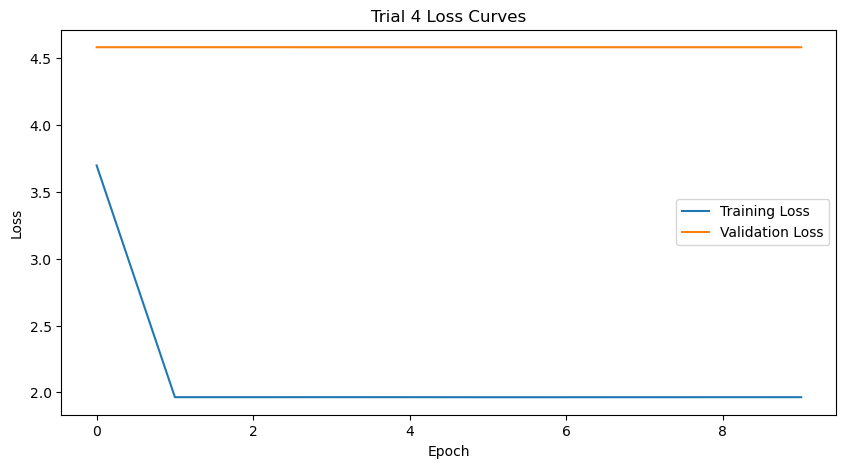

[I 2024-12-07 21:44:21,575] Trial 4 finished with value: 4.581511040123141 and parameters: {'lr': 0.0004727889979620643, 'inst_w': 0.014815001400323503, 'sem_w': 0.00013637080452503608, 'itm_w': 0.7203677321377528, 'lambda': 0.00033301918854032115}. Best is trial 1 with value: 2.031923396246774.


finished initializing


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 1, Loss: 4.121718512285476


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 1, Loss: 4.323220486543616


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 2, Loss: 4.10383513789849


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 2, Loss: 4.323039210572535


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 3, Loss: 4.1047012288565075


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 3, Loss: 4.322468027776601


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 4, Loss: 4.1064783188053955


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 4, Loss: 4.3226790817416445


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 5, Loss: 4.107824661587709


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 5, Loss: 4.321288877603959


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 6, Loss: 4.109717814981004


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 6, Loss: 4.321279301935313


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 7, Loss: 4.112062138465694


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 7, Loss: 4.322114584397297


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 8, Loss: 4.113644151879637


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 8, Loss: 4.320825294572479


  0%|          | 0/447 [00:00<?, ?it/s]

train: Epoch 9, Loss: 4.115731776960744


  0%|          | 0/49 [00:00<?, ?it/s]

eval: Epoch 9, Loss: 4.321747468442333


  0%|          | 0/447 [00:00<?, ?it/s]

[W 2024-12-07 23:07:33,807] Trial 5 failed with parameters: {'lr': 3.57965635465319e-05, 'inst_w': 0.04645140877198957, 'sem_w': 0.005713286466069595, 'itm_w': 0.00036067073941497234, 'lambda': 0.00010707660928078404} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/chelsea/anaconda3/envs/tfood_torch/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_25734/1366879358.py", line 48, in objective
    final_loss = image2recipe.train(trial)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_25734/464826059.py", line 160, in train
    output = self.model(images, image_labels, recipe_enc_src)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chelsea/anaconda3/envs/tfood_torch/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self.

KeyboardInterrupt: 

In [19]:
##  Optuna

# name of the resuting optuna file
# current_time = datetime.now().strftime('%m-%d_%H-%M')
# study_name=f"recipe_checkpoint_{current_time}"
study_name= "recipe_checkpoint_12-07_13-46"

print(torch.__version__)
print(torch.cuda.is_available())
vocab_size = tokenizer_recipes.vocab_size
param_path = os.path.join(GOOGLE_DRIVE_PATH, "models/best_model_jake.pth")
recipe_embeddings_path  = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")


def objective(trial):
    kwargs = {
        'epochs': 10,
        'ingredient_tokens': filtered_df['tokenized_ingredients'].to_list(),
        'instruction_tokens': filtered_df['tokenized_instructions'].to_list(),
        'title_tokens': filtered_df['tokenized_titles'].to_list(),
        'image_tensors': filtered_tensors,
        'image_labels': filtered_df['Image_Name'],
        'device': device,
        'vocab_size': vocab_size,
        'max_len': total_max,
        'clip_model': clip_model,
        'optimizer': 'adam',
        'learning_rate': trial.suggest_float('lr', 1e-6, 1e-2, log=True),
        'batch_size': 10,
        'instance_weight': trial.suggest_float('inst_w', 1e-5, 1, log=True),
        'sem_weight': trial.suggest_float('sem_w', 1e-5, 1, log=True),
        'itm_weight': trial.suggest_float('itm_w', 1e-5, 1, log=True),
        'initial_margin': 0.05,
        'margin_step': 0.005,
        'max_margin':0.3,
        'best_model_parameters_path': param_path,
        'decoder_lambda': trial.suggest_float('lambda', 1e-5, 1, log=True),
        'topk': 10
        # 'max_lengths': {
        #     'ingredient_tokens': max_length_ing,
        #     'instruction_tokens': max_length_inst,
        #     'title_tokens': max_length_title
        # }
    }
    torch.cuda.empty_cache() #clear cache before each run

    image2recipe = Trainer(**kwargs)
    final_loss = image2recipe.train(trial)
    image2recipe.plot_learning_loss_curves(name=f"{study_name}__Trial_{trial.number}",
                                           title=f"Trial {trial.number} Loss Curves")
    return final_loss

# Create a study object and optimize the objective function.
# A new file will be saved called {study_name}.db containing the study
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='minimize',
                            sampler=optuna.samplers.RandomSampler(),
                            pruner=optuna.pruners.MedianPruner(),
                            load_if_exists=True # allows for study to be resumed
                            )
study.optimize(objective, n_trials=10)

pruned_trials = study.get_trials(states=(optuna.trial.TrialState.PRUNED,))
complete_trials = study.get_trials(states=(optuna.trial.TrialState.COMPLETE,))

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

Now that the model is trained, use it to guess images recipes!

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  #same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #same norm as training
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0) #add batch dim of 1 at 0 indice

def extract_image_features(image, model, device):
  model.eval()
  with torch.no_grad():
      image_features = model.image_encoder(image.to(device))
      image_features = torch.nn.functional.normalize(image_features, p=2, dim=-1)
  return image_features

def load_model(model_path):
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

image_path = "insert test image path"
tensor_image = preprocess_image(image_path)
image2recipe = load_model(param_path)
image_features = extract_image_features(tensor_image, image2recipe.model, device)
print(image_features.shape)

recipe_embeddings = np.load(recipe_embeddings_path)


#Compute cosine similarities

